# Example 5.5 — Bayesian analysis of LED Accelerated Degradation with Dual Stresses

**Author:** Justin Ryan  
**Created:** 2025-09-24  
**Updated:** 2025-09-29  
**Version:** 1.1  

---
## Problem Statement
Repeat Example 5.3 using the Bayesian approach using the same degradation model. Also determine the 90% confidence of use level life.

Priors can be assumed as 

- $a \sim\mathcal{LN} (2\times 10^{-8},0.5)$
- $b \sim\mathcal{LN} (1,0.5)$
- $E_{a}\sim\mathcal{LN} (0.3,0.3)$
- $n \sim\mathcal{LN} (1.2,0.5)$
- $c \sim\mathcal{Uniform} (-0.1, 0.1)$ 
- $\sigma_\varepsilon\sim\mathcal{Uniform} (1\times 10^{-4},2) $

---

## Solution

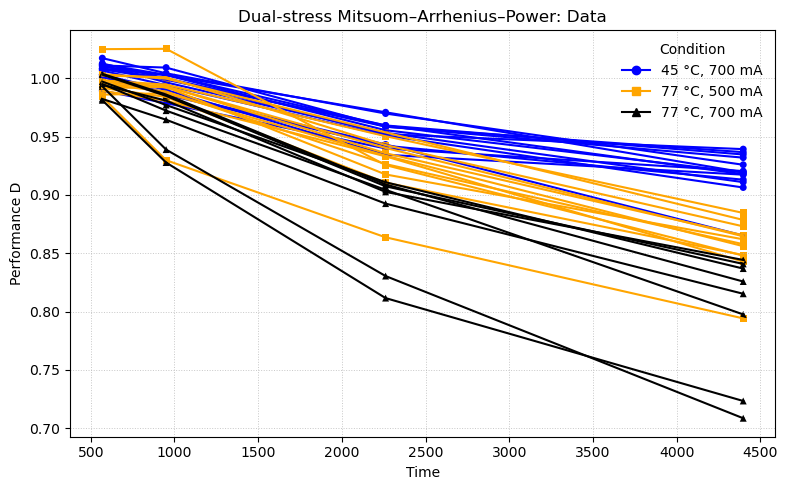

C:\Users/leaat/Dropbox/University of Maryland/ENRE648 - PPoF Chap Review - Degradation Analysis/ADT Fitters Module\ADT_fitters.py:3460: RuntimeWarning: overflow encountered in power
  denom = 1.0 + c + a * (base ** b)


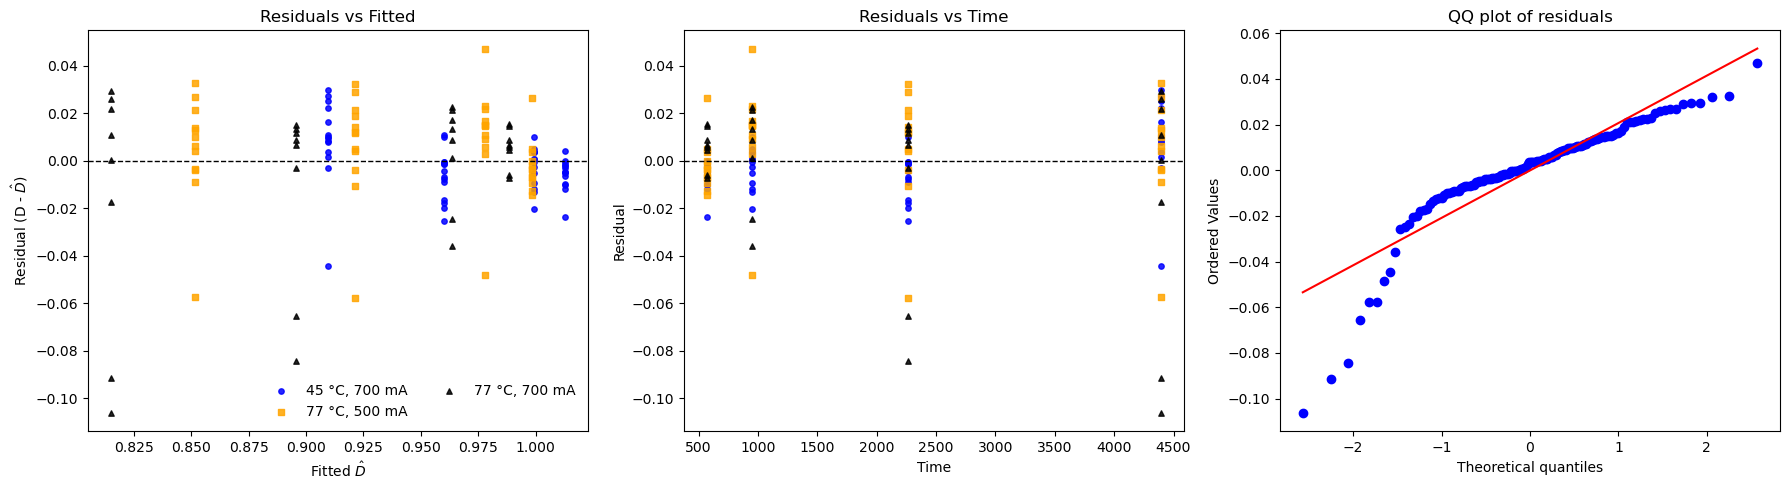

100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:23<00:00, 84.56it/s]


### Degradation / performance model (with offset)

**Model form (performance scale)**

This variant adds a vertical-offset parameter \(c\) to the Mitsuom model:

$$
D(t, T, S)
= \left[
  1 + c
  + a \left(
    \exp\!\left(\frac{E_a}{k_B}
      \left(\frac{1}{T_{\text{use}}} - \frac{1}{T}\right)
    \right)
    \, S^{n} \, t
  \right)^{b}
\right]^{-1}.
$$

The additional \(c\) term allows the starting performance level or
overall “height” of the degradation curve to shift slightly away from
exactly 1 while still maintaining \(1 + c > 0\).

**Parameters:**

- **$c$** – offset on the damage term (controls vertical position of the curve)  
- **$a$** – scale factor on the accumulated damage term  
- **$b$** – time/curvature exponent (how sharply degradation accelerates)  
- **$E_{a}$** – Arrhenius activation energy (eV)  
- **$n$** – power exponent on the second stress \(S\) (e.g. current in mA)  
- **$T_{\text{use}}, S_{\text{use}}$** – fixed use-level stresses (inputs, not fitted)

### Bayesian (additive) Parameter Estimates (95% CrI)

| Parameter | Mean | Median | 95% CrI |
|-----------|------|--------|----------------|
| a | 2.0479e-08 | 1.84812e-08 | [6.66233e-10, 4.00485e-08] |
| b | 4.54474 | 0.95212 | [0.150558, 1.11123] |
| Ea (eV) | 0.259087 | 0.259725 | [0.0311127, 0.310528] |
| n | 1.28544 | 1.14889 | [0.602031, 2.52766] |
| c | 0.0269066 | -0.0251325 | [-0.0896112, 0.05994] |
| $\sigma$ | 0.0490008 | 0.0223739 | [0.0191544, 0.058534] |

C:\Users/leaat/Dropbox/University of Maryland/ENRE648 - PPoF Chap Review - Degradation Analysis/ADT Fitters Module\ADT_fitters.py:4201: RuntimeWarning: overflow encountered in power
  denom = 1.0 + _c[:, None] + _a[:, None] * (base ** _b[:, None])


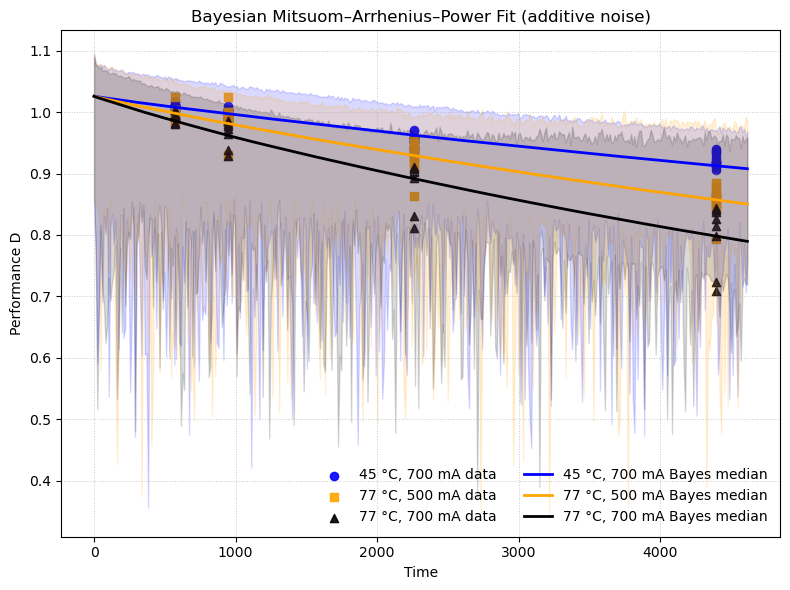

C:\Users/leaat/Dropbox/University of Maryland/ENRE648 - PPoF Chap Review - Degradation Analysis/ADT Fitters Module\ADT_fitters.py:4299: RuntimeWarning: overflow encountered in scalar power
  return 1.0 / (1.0 + c + a * (base ** b))


In [ ]:
# EXAMPLE 5.5
import pandas as pd
import sys 
sys.path.append("C:/Users/leaat/Dropbox/University of Maryland/ENRE648 - PPoF Chap Review - Degradation Analysis/ADT Fitters Module")
df = pd.read_csv("C:/Users/leaat/Dropbox/University of Maryland/ENRE648 - PPoF Chap Review - Degradation Analysis/Modarres Chapter Validation/data/Example_5.3_LED_degradation_data.csv")

#Remove outlier units
df = df[~df["Unit"].isin([15, 22])].reset_index(drop=True)  #[3, 5, 15, 22]

# --- Tidy to long format: (Unit, T_C, I_mA, time_hr, D) ---
time_cols = [c for c in df.columns if "(hr)" in c]
df = df.melt(
    id_vars=["Unit", "T_C", "I_mA"],
    value_vars=time_cols,
    var_name="time_hr",
    value_name="D"
).dropna()
df["time_hr"] = df["time_hr"].str.extract(r"(\d+(?:\.\d+)?)").astype(float)
df = df.sort_values(["Unit", "time_hr"]).reset_index(drop=True)

T_use_C = 30    # deg C
I_use_mA = 400  # mA
Df = 0.70       # relative luminosity

priors = {
    "a":    ("Lognormal", -17.8, 0.2),
    "b":    ("Lognormal", -0.05, 0.2),
    "Ea":   ("Lognormal", -1.3, 0.3),
    "n":    ("Lognormal", -0.05, 0.2),
    "c":    ("Uniform",   -0.1, 0.1),
    "sigma":("Lognormal",    0.001, 0.1)}

from ADT_fitters import Fit_ADT_Mitsuom_Arrhenius_Power1
fit_dual = Fit_ADT_Mitsuom_Arrhenius_Power1(
    degradation=df["D"],
    temp_C=df["T_C"],
    stress_S=df["I_mA"],      # second stress array
    time=df["time_hr"],
    unit=df["Unit"],
    stress_use_T=T_use_C,
    stress_use_S=I_use_mA,      # e.g. use-level current
    Df=Df,
    CI=0.95,
    method="Bayesian",
    noise="additive",
    priors=None,
    # priors=priors,
    show_data_plot=True,
    show_LSQ_diagnostics=True,
    show_noise_bounds=True,
    show_use_TTF_dist=True,
    print_results=True,
)